# Replacing Covid Tracking Project - Simplified Workflow

>NOTE: ~~See  final workflow in the final script: `data_acquisition.py`~~ **as of 08/12, the development of the data acquisition code has moved back to "`Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipynb`"**

- 08/09/21

- This is a companion notebook to `Exploring Options for Replacing Covid Tracking Project Data_08-2021`
- The goal is to only save the final pieces of code required to produce the dataset, and to exclude testing things out and info displays

## Summary

- Download kaggle data for the deaths and cases counts
- Download Socrata HHS data for hospital info
- Get all as daily frequency and with State Abbrevs before merging

In [1]:
# !pip install -U fsds
from fsds.imports import *

import os,zipfile,json,joblib
pd.set_option('display.max_columns',0)

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [2]:
## Appending folder with functions
%load_ext autoreload 
%autoreload 2
# import sys
# sys.path.append('.')

import functions as fn
# help(fn)

# Data

## Specifying File Destinations

In [3]:
## Specifying data storage folders
fpath_raw = r"data_raw"
fpath_clean = r"data/"
[os.makedirs(fpath,exist_ok=True) for fpath in [fpath_clean,fpath_raw]];

## Covid-19 Data From Johns Hopkins University

- https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university
- Comes with CONVENIENT_ files and RAW_ files.

In [4]:
## Download kaggle jhu data and make zipfile object
!kaggle datasets download -p "{fpath_raw}" -d antgoldbloom/covid19-data-from-john-hopkins-university

jhu_data_zip = zipfile.ZipFile(os.path.join(fpath_raw,'covid19-data-from-john-hopkins-university.zip'))
jhu_data_zip.namelist()

covid19-data-from-john-hopkins-university.zip: Skipping, found more recently modified local copy (use --force to force download)


['CONVENIENT_global_confirmed_cases.csv',
 'CONVENIENT_global_deaths.csv',
 'CONVENIENT_global_metadata.csv',
 'CONVENIENT_us_confirmed_cases.csv',
 'CONVENIENT_us_deaths.csv',
 'CONVENIENT_us_metadata.csv',
 'RAW_global_confirmed_cases.csv',
 'RAW_global_deaths.csv',
 'RAW_us_confirmed_cases.csv',
 'RAW_us_deaths.csv']

In [5]:
## Getting State Abbrevs
state_abbrevs = pd.read_csv('Reference Data/united_states_abbreviations.csv')

## Making dicts of Name:Abbrev and Abbrev:Name
state_to_abbrevs_map = dict(zip(state_abbrevs['State'],state_abbrevs['Abbreviation']))
abbrev_to_state_map = dict(zip(state_abbrevs['Abbreviation'],state_abbrevs['State']))
# state_to_abbrevs_map

### prep `df_metadata`

In [6]:
# metadata
file = 'CONVENIENT_us_metadata.csv'
jhu_data_zip.extract(file,path=fpath_raw)
df_metadata = pd.read_csv(os.path.join(fpath_raw,file))

## Adding State Abbrevas to kaggle metadata
df_metadata.insert(1,'State_Code',df_metadata['Province_State'].map(state_to_abbrevs_map))
print(df_metadata.isna().sum())

## Dropping us territories
df_metadata.dropna(subset=['State_Code'], inplace=True)

## Saving county info
df_metadata.to_csv(os.path.join(fpath_clean,"us_metadata_counties.csv"),index=False)
df_metadata

Province_State    0
State_Code        6
Admin2            6
Population        0
Lat               0
Long              0
dtype: int64


,Province_State,State_Code,Admin2,Population,Lat,Long
0,Alabama,AL,Autauga,55869,32.539527,-86.644082
1,Alabama,AL,Baldwin,223234,30.727750,-87.722071
2,Alabama,AL,Barbour,24686,31.868263,-85.387129
3,Alabama,AL,Bibb,22394,32.996421,-87.125115
4,Alabama,AL,Blount,57826,33.982109,-86.567906
...,...,...,...,...,...,...
3337,Wyoming,WY,Teton,23464,43.935225,-110.589080
3338,Wyoming,WY,Uinta,20226,41.287818,-110.547578
3339,Wyoming,WY,Unassigned,0,0.000000,0.000000
3340,Wyoming,WY,Washakie,7805,43.904516,-107.680187


In [7]:
## Saving a states-only version with aggregated populations and mean lat/long
df_state_metadata = df_metadata.groupby('Province_State',as_index=False).agg({'Population':'sum',
                                               "Lat":'mean',"Long":"mean"})
df_state_metadata.insert(1,'State_Code',df_state_metadata['Province_State'].map(state_to_abbrevs_map))
df_state_metadata.to_csv(os.path.join(fpath_clean,"us_metadata_states.csv"),index=False)
df_state_metadata

,Province_State,State_Code,Population,Lat,Long
0,Alabama,AL,4903185,31.931113,-84.196785
1,Alaska,AK,740995,56.628273,-139.571540
2,Arizona,AZ,7278717,29.714033,-98.349911
3,Arkansas,AR,3017804,34.005087,-90.033096
4,California,CA,39512223,36.582496,-116.704308
5,Colorado,CO,5758736,37.755612,-102.289687
6,Connecticut,CT,3565287,33.290944,-58.125464
7,Delaware,DE,973764,23.465566,-45.319942
8,District of Columbia,DC,705749,12.968059,-25.672187
9,Florida,FL,21477737,28.101892,-80.303621


In [8]:
## Making and saving remapping dicts
import joblib

state_to_abbrevs_meta = dict(zip(df_state_metadata['Province_State'],df_state_metadata['State_Code']))
abbrev_to_state_meta = dict(zip(df_state_metadata['State_Code'],df_state_metadata['Province_State']))

joblib.dump(state_to_abbrevs_meta, os.path.join(fpath_clean,'state_names_to_codes_map.joblib'))
joblib.dump(abbrev_to_state_meta, os.path.join(fpath_clean,'state_codes_to_names_map.joblib'))

## save mapper fo state to code for function
mapper_path = os.path.join(fpath_clean,'state_names_to_codes_map.joblib')
mapper_path

'data/state_names_to_codes_map.joblib'

In [9]:
def load_raw_ts_file(jhu_data_zip, file = 'RAW_us_confirmed_cases.csv',
                     mapper_path='data/state_names_to_codes_map.joblib',
                    verbose=True):
    
    if verbose: 
        print(f"Loading data from {file}")
    state_to_abbrevs_meta = joblib.load(mapper_path)
    
    ## Extract and load csv
    jhu_data_zip.extract(file)
    data = pd.read_csv(file)
    
    ## Drop states not included in metadata
    data.insert(1,'State_Code',data['Province_State'].map(state_to_abbrevs_meta))
    data.dropna(subset=['State_Code'],inplace=True)
    return data



def melt_df_to_ts(df_cases,value_name, var_name='Date',
                  multi_index_cols=['State_Code','Date'],
                  id_cols = ['Province_State',"State_Code",'Admin2'],
                  cols_to_drop=['iso2','iso3','code3','UID','Country_Region',
                                'Combined_Key','Lat','Long_','FIPS']):
    
#     value_cols = [c for c in df_cases.columns if c not in [*cols_to_drop,*id_cols]]
    
    ## Remove any cols not in the actual dataframe
    id_cols = [c for c in id_cols if c in df_cases.columns] 
    cols_to_drop = [c for c in cols_to_drop if c in df_cases.columns] 
    
    ## CHECKING FOR NON-DATE COLS TO REMOVE
    value_cols = [c for c in df_cases.columns if c not in [*id_cols,*cols_to_drop]]
    value_cols = list(filter(lambda x: len(x.split('/'))>1,value_cols))
    
    
    df_cases_ts = pd.melt(df_cases, 
                          id_vars=id_cols, value_vars=value_cols,
                          var_name=var_name, value_name=value_name)
    
    df_cases_ts['Date'] = pd.to_datetime(df_cases_ts['Date'])
    df_cases_ts = df_cases_ts.set_index(multi_index_cols).sort_index()
    return df_cases_ts

In [10]:
## Prep ` df_cases_ts`
df_cases = load_raw_ts_file(jhu_data_zip, file = 'RAW_us_confirmed_cases.csv',)
df_cases_ts = melt_df_to_ts(df_cases,'Cases')
df_cases_ts

Loading data from RAW_us_confirmed_cases.csv


Province_State          Admin2  Cases
State_Code Date                                            
AK         2020-01-22         Alaska  Aleutians East      0
           2020-01-22         Alaska  Aleutians West      0
           2020-01-22         Alaska       Anchorage      0
           2020-01-22         Alaska          Bethel      0
           2020-01-22         Alaska     Bristol Bay      0
...                              ...             ...    ...
WY         2021-08-13        Wyoming           Teton   4068
           2021-08-13        Wyoming           Uinta   2593
           2021-08-13        Wyoming      Unassigned      0
           2021-08-13        Wyoming        Washakie    967
           2021-08-13        Wyoming          Weston    705

[1901520 rows x 3 columns]

In [11]:
## Prep df_deaths_ts
df_deaths = load_raw_ts_file(jhu_data_zip,file = 'RAW_us_deaths.csv')
df_deaths_ts = melt_df_to_ts(df_deaths,'Deaths')
df_deaths_ts

Loading data from RAW_us_deaths.csv


Province_State          Admin2  Deaths
State_Code Date                                             
AK         2020-01-22         Alaska  Aleutians East       0
           2020-01-22         Alaska  Aleutians West       0
           2020-01-22         Alaska       Anchorage       0
           2020-01-22         Alaska          Bethel       0
           2020-01-22         Alaska     Bristol Bay       0
...                              ...             ...     ...
WY         2021-08-13        Wyoming           Teton      11
           2021-08-13        Wyoming           Uinta      14
           2021-08-13        Wyoming      Unassigned       0
           2021-08-13        Wyoming        Washakie      26
           2021-08-13        Wyoming          Weston       6

[1901520 rows x 3 columns]

In [12]:
pd.concat([df_cases_ts,df_deaths_ts],axis=1)

Province_State          Admin2  ...          Admin2 Deaths
State_Code Date                                       ...                       
AK         2020-01-22         Alaska  Aleutians East  ...  Aleutians East      0
           2020-01-22         Alaska  Aleutians West  ...  Aleutians West      0
           2020-01-22         Alaska       Anchorage  ...       Anchorage      0
           2020-01-22         Alaska          Bethel  ...          Bethel      0
           2020-01-22         Alaska     Bristol Bay  ...     Bristol Bay      0
...                              ...             ...  ...             ...    ...
WY         2021-08-13        Wyoming           Teton  ...           Teton     11
           2021-08-13        Wyoming           Uinta  ...           Uinta     14
           2021-08-13        Wyoming      Unassigned  ...      Unassigned      0
           2021-08-13        Wyoming        Washakie  ...        Washakie     26
           2021-08-13        Wyoming          Weston  ...          Weston      6

[1901520 rows x 6 columns]

### Join Dataset and Make STATES dict

In [13]:
unique_states = list(abbrev_to_state_meta.keys())
len(unique_states)

52

In [14]:
STATES = {}

for state in unique_states:
    ## Reset the state's datafranes for pd.merge
    df_cases_temp = df_cases_ts.loc[state].reset_index()
    df_deaths_temp = df_deaths_ts.loc[state].reset_index()

    ## Merge using date and Admin2/county
    df_merged = pd.merge(df_cases_temp, df_deaths_temp, on=['Date','Admin2'])
    df_merged_ts = df_merged.set_index("Date").resample('D').sum()

    df_merged_ts.columns = [f"{c}-{state}" for c in df_merged_ts.columns]    
    
    STATES[state] = df_merged_ts.copy()

STATES.keys()

dict_keys(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])

## New Hospital Data [Added 08/13/21]

- From "`0_Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipynb`"

In [15]:
def get_hospital_data():
    offset = 0
    ## Getting Hospital Capacity Data
    base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
    page = 0
    results = []

    ## seting random, large page-len
    page_len = 1000

    while (page_len>0):
        try:
            print(f"[i] Page {page} (offset = {offset})")
            url = base_url+f"?$offset={offset}"
            df_temp = pd.read_csv(url)
            results.append(df_temp)

            page_len = len(df_temp)
            offset+=page_len
            page+=1
        except Exception as e:
            print('[!] ERROR:')
            print(e)
            print('-- returning raw results list instead of dataframe..')
            return results
        
    return pd.concat(results)

# hospital_df = get_hospital_data()
# hospital_df

In [16]:
# ## Get hospital data with function
# df1 = get_hospital_data()
# df1 = df1.rename({'state':'State_Code',
#                  'date','Date'})
# df1['Date'] = pd.to_datetime(df1['Date'])
# df1 = df1.sort_values(['State_Code','Date'])
# df1

In [17]:
import datetime as dt
today = dt.date.today().strftime("%m-%d-%Y")
# df1.to_csv(os.path.join(fpath_raw,f'hospital_data_{today}.csv'))


### Saving Columns

In [18]:
class ColumnDict(dict):
    """Inherits from a normal dictionary.
    
    Methods:
        find_expr_cols: methods for finding columns based on expressions
                        saves the column names under with the expression  as key
        get_all_values: gets list of all unique values stored in dict
    Adds 
    Also saved keep_keys True/False dict of expressions that should be kept or dropped
    """
    keep_keys = {True:list(),False:list(),'id':list()} # Expressions 
    keep_cols = {True:list(),False:list()} # column names
    
    def __init__(self, id_cols=[],*args,**kwargs):

        self.id_cols=id_cols
        ## Empty list of keep keys/cols
#         self['id'] = self.id_cols
        self.keep_keys = {True:list(),False:list(),'id':self.id_cols} # Expressions 
        self.keep_cols = {True:[*self.id_cols],False:list()} # column names
    #     id_cols = list() ## id columns to be auto-kept 
        super().__init__(*args,**kwargs)
    
        

    
    def get_all_values(self,keep=None):
        """Retrieves list of unique column names:
        Args:
            keep (None, True, False): determines subset of columns returned
            # Adapter from: https://www.geeksforgeeks.org/python-concatenate-dictionary-value-lists/
            """
        if keep is None:
            from itertools import chain
            return [*self.id_cols,*set(list(chain(*self.values())))]
        
        elif keep==True:
            col_list = list(set(self.keep_cols[keep]))
            return [*self.id_cols, *[c for c in col_list if c not in self.id_cols]]
#             return list(set([*self.id_cols,*]))
        elif keep==False:
            return list(set(self.keep_cols[keep]))

        
        
    def find_expr_cols(self,expressions,df,keep,exlcude_known_cols=None):
        """Saves lists of column names as values in dict
        Args:
            Expresssions (str,list): patterns to find in column names 
            df (DataFrame): dataframe to check
            keep (bool): saves expr and cols keep_cols/keep_keys as True or False
            
        TO DO:
            exlcude_known_cols (NOT IMPLEMENTED YET): will check if found columns 
                                are already in any of the known lists of cols
                                
                                
                                
        EXAMPLE USAAGE:
        >>> COLUMNS = ColumnDict()
        >>> COLUMNS.find_expr_cols(['staffing','previous_day','coverage'],
                                    df1,keep=False)
        """
            
        if isinstance(expressions,str):
                expressions = [expressions]
                
        for expr in expressions:
            found_cols = [c for c in df.columns if expr in c]
            self[expr] = found_cols

            ## Save exression and fond_cols to keep_keys/keep_cols
            self.keep_keys[keep].append(expr)
            
            [self.keep_cols[keep].append(c) for c in found_cols if c not in self.keep_cols[keep]]





### Making `df_hospitals`

In [19]:
FULL_WORKFLOW =True

import datetime as dt
today = dt.date.today().strftime("%m-%d-%Y")
# df1.to_csv(os.path.join(fpath_raw,f'hospital_data_{today}.csv'))


if FULL_WORKFLOW:
    ## Get hospital data with function

    ## Get hospital data with function
    df1 = get_hospital_data()
    df1 = df1.rename({'state':'State_Code',
                     'date':'Date'},axis=1)
    df1['Date'] = pd.to_datetime(df1['Date'])
    df1 = df1.sort_values(['State_Code','Date'])

COLUMNS = ColumnDict(id_cols=['State_Code','Date'])

## saving names to DROP to COLUMNS dict
drop_col_expressions = ['staff','previous_day','coverage','onset']
COLUMNS.find_expr_cols(drop_col_expressions,df1,keep=False)


## saving names to KEEP to COLUMNS dict
keep_col_expressions = ['inpatient_bed','adult_icu_bed','utilization',
                        'total_adult_patients','total_pediatric_patients',
                       'percent_of_inpatients_with_covid','deaths']
COLUMNS.find_expr_cols(keep_col_expressions,df1,keep=True)


## Making df_hospitals
df_hospitals = df1[COLUMNS.get_all_values(keep=True)].copy()
df_hospitals = df_hospitals.set_index(COLUMNS.id_cols).sort_index()
df_hospitals#.loc['MD',['inpatient_beds_utilization']].plot()

[i] Page 0 (offset = 0)
[i] Page 1 (offset = 1000)
[i] Page 2 (offset = 2000)
[i] Page 3 (offset = 3000)
[i] Page 4 (offset = 4000)
[i] Page 5 (offset = 5000)
[i] Page 6 (offset = 6000)
[i] Page 7 (offset = 7000)
[i] Page 8 (offset = 8000)
[i] Page 9 (offset = 9000)
[i] Page 10 (offset = 10000)
[i] Page 11 (offset = 11000)
[i] Page 12 (offset = 12000)
[i] Page 13 (offset = 13000)
[i] Page 14 (offset = 14000)
[i] Page 15 (offset = 15000)
[i] Page 16 (offset = 16000)
[i] Page 17 (offset = 17000)
[i] Page 18 (offset = 18000)
[i] Page 19 (offset = 19000)
[i] Page 20 (offset = 20000)
[i] Page 21 (offset = 21000)
[i] Page 22 (offset = 22000)
[i] Page 23 (offset = 23000)
[i] Page 24 (offset = 24000)
[i] Page 25 (offset = 25000)
[i] Page 26 (offset = 26000)
[i] Page 27 (offset = 27000)
[i] Page 28 (offset = 28000)
[i] Page 29 (offset = 28424)


inpatient_beds_used_covid_coverage  ...  adult_icu_bed_utilization
State_Code Date                                           ...                           
AK         2020-03-23                                  1  ...                        NaN
           2020-03-24                                  1  ...                        NaN
           2020-03-25                                  1  ...                        NaN
           2020-03-26                                  1  ...                        NaN
           2020-03-27                                  2  ...                        NaN
...                                                  ...  ...                        ...
WY         2021-08-10                                 27  ...                   0.455882
           2021-08-11                                 29  ...                   0.459854
           2021-08-12                                 29  ...                   0.463235
           2021-08-13                                 29  ...                   0.423358
           2021-08-14                                 29  ...                   0.423358

[28424 rows x 40 columns]

In [20]:
# ## Prep Hospital Data

# df1 = get_hospital_data()
# df1['date'] = pd.to_datetime(df1['date'])

# ## Remnaming state columsn to match
# df1 = df1.rename({'state':'State_Code'},axis=1)
# df1['Province_State'] = df1['State_Code'].map(abbrev_to_state_map)
# df1 = df1[df1['Province_State'].isin(state_abbrevs['State'])]
# df1 = df1.sort_values(['Province_State','date'])
# df1 = df1.drop_duplicates(keep='first')
# df1

In [21]:
# ## needed cols (utilization )
# inpatient_bed_util_cols = [c for c in df1.columns if 'inpatient_beds_utilization' in c]
# adult_icu_util_cols = [c for c in df1.columns if 'adult_icu_bed_utilization'in c]
# KEEP_COLS = ['date','Province_State','State_Code',*inpatient_bed_util_cols,*adult_icu_util_cols]

In [22]:
# df1[df1.duplicated(keep=False)]

In [23]:
# ## Making df_hospitals
# df_hospitals = df1[KEEP_COLS].copy()
# df_hospitals = df_hospitals.set_index(['State_Code','date']).sort_index()
# df_hospitals#.loc['MD',['inpatient_beds_utilization']].plot()

## Comparing the 3 tables

In [24]:
df_hospitals

inpatient_beds_used_covid_coverage  ...  adult_icu_bed_utilization
State_Code Date                                           ...                           
AK         2020-03-23                                  1  ...                        NaN
           2020-03-24                                  1  ...                        NaN
           2020-03-25                                  1  ...                        NaN
           2020-03-26                                  1  ...                        NaN
           2020-03-27                                  2  ...                        NaN
...                                                  ...  ...                        ...
WY         2021-08-10                                 27  ...                   0.455882
           2021-08-11                                 29  ...                   0.459854
           2021-08-12                                 29  ...                   0.463235
           2021-08-13                                 29  ...                   0.423358
           2021-08-14                                 29  ...                   0.423358

[28424 rows x 40 columns]

In [25]:
df_deaths_ts

Province_State          Admin2  Deaths
State_Code Date                                             
AK         2020-01-22         Alaska  Aleutians East       0
           2020-01-22         Alaska  Aleutians West       0
           2020-01-22         Alaska       Anchorage       0
           2020-01-22         Alaska          Bethel       0
           2020-01-22         Alaska     Bristol Bay       0
...                              ...             ...     ...
WY         2021-08-13        Wyoming           Teton      11
           2021-08-13        Wyoming           Uinta      14
           2021-08-13        Wyoming      Unassigned       0
           2021-08-13        Wyoming        Washakie      26
           2021-08-13        Wyoming          Weston       6

[1901520 rows x 3 columns]

In [26]:
df_cases_ts

Province_State          Admin2  Cases
State_Code Date                                            
AK         2020-01-22         Alaska  Aleutians East      0
           2020-01-22         Alaska  Aleutians West      0
           2020-01-22         Alaska       Anchorage      0
           2020-01-22         Alaska          Bethel      0
           2020-01-22         Alaska     Bristol Bay      0
...                              ...             ...    ...
WY         2021-08-13        Wyoming           Teton   4068
           2021-08-13        Wyoming           Uinta   2593
           2021-08-13        Wyoming      Unassigned      0
           2021-08-13        Wyoming        Washakie    967
           2021-08-13        Wyoming          Weston    705

[1901520 rows x 3 columns]

In [27]:
# raise Exception('Stop here!')

# **BOOKMARK 08/14/21** - combining new hospital data 

## Join Dataset and Make STATES dict
- Note: try to join hospital data here too??

In [28]:
unique_states = np.unique(df_hospitals.index.get_level_values(0))
len(unique_states)

53

### Test individual state before making loop

In [29]:
## Saving CSVs
folder = os.path.join(fpath_clean,'state_data/')
os.makedirs(folder,exist_ok=True)
os.listdir(folder)

[]

In [35]:
## ESSENTIAL BLOCK FOR LOOP
state = 'MD'
df_cases_temp = df_cases_ts.loc[state].sort_index().resample("D").sum().diff().fillna(0)
df_deaths_temp = df_deaths_ts.loc[state].sort_index().resample("D").sum().diff().fillna(0)
df_hospital_temp = df_hospitals.loc[state].sort_index().resample("D").sum().ffill().fillna(0)

In [36]:
df_hospital_temp

,inpatient_beds_utilization_numerator,inpatient_bed_covid_utilization_coverage,percent_of_inpatients_with_covid_denominator,adult_icu_bed_utilization_denominator,inpatient_beds_utilization,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization,staffed_adult_icu_bed_occupancy,total_adult_patients_hospitalized_confirmed_covid,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization_denominator,adult_icu_bed_utilization_coverage,adult_icu_bed_covid_utilization_coverage,percent_of_inpatients_with_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization_numerator,inpatient_beds_utilization_coverage,total_pediatric_patients_hospitalized_confirmed_covid,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization_numerator,inpatient_beds_used,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,inpatient_beds_used_covid,deaths_covid,inpatient_beds,total_staffed_adult_icu_beds,adult_icu_bed_covid_utilization,percent_of_inpatients_with_covid_numerator,inpatient_beds_utilization_denominator,adult_icu_bed_utilization
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,4.0,1.0,4.0,0.0,0.666667,0.0,0.000000,0.0,0.0,0.000000,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,6.0,0.000000
2020-03-02,8.0,2.0,8.0,0.0,1.333333,0.0,0.000000,0.0,0.0,0.000000,12.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,12.0,0.0,0.000000,0.0,12.0,0.000000
2020-03-03,4.0,1.0,4.0,0.0,0.666667,0.0,0.000000,0.0,0.0,0.000000,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,6.0,6.0,0.0,0.000000,0.0,6.0,0.000000
2020-03-04,4.0,1.0,4.0,0.0,0.666667,0.0,0.000000,0.0,0.0,0.000000,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,6.0,0.000000
2020-03-05,4.0,1.0,4.0,0.0,0.666667,0.0,0.000000,0.0,0.0,0.000000,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,6.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-10,8520.0,52.0,8460.0,1307.0,0.819073,645.0,0.062634,893.0,444.0,0.076241,10298.0,53.0,52.0,52.0,630.0,139.0,53.0,5.0,1269.0,893.0,8520.0,15.0,645.0,0.0,10402.0,1307.0,0.109535,645.0,10402.0,0.683244
2021-08-11,9649.0,59.0,9589.0,1287.0,0.839116,689.0,0.060465,911.0,475.0,0.071853,11395.0,60.0,59.0,59.0,673.0,144.0,60.0,6.0,1249.0,911.0,9649.0,16.0,689.0,3.0,11499.0,1287.0,0.115292,689.0,11499.0,0.707848
2021-08-12,19206.0,118.0,19086.0,2586.0,1.664442,1376.0,0.120332,1796.0,964.0,0.144189,22870.0,120.0,118.0,118.0,1348.0,298.0,120.0,12.0,2510.0,1796.0,19206.0,28.0,1376.0,10.0,23078.0,2586.0,0.237450,1376.0,23078.0,1.389018


<AxesSubplot:xlabel='Date'>

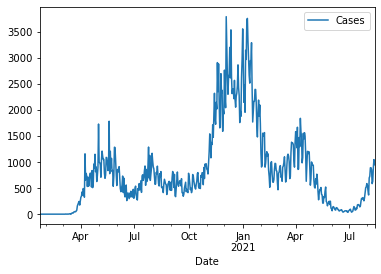

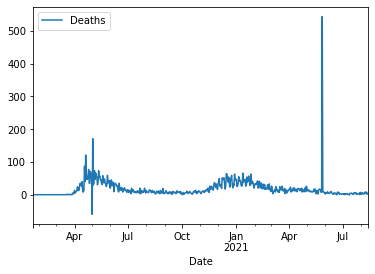

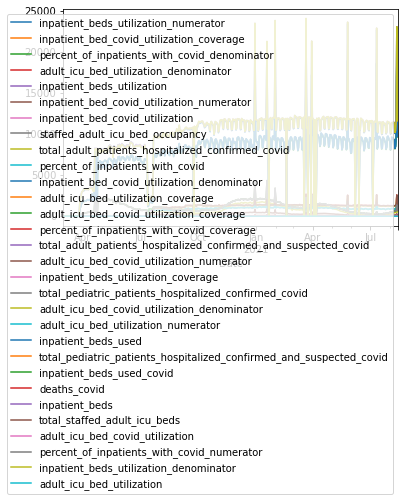

In [38]:
df_cases_temp.plot()
df_deaths_temp.plot()
df_hospital_temp.plot()

In [37]:
raise Exception('Stop here')

Exception: Stop here

In [ ]:

display(df_cases_temp.head(),df_deaths_temp.head(),df_hospital_temp.head())

### Attempting Various versions of joins

In [ ]:
df_state = pd.concat([df_cases_temp,df_deaths_temp,df_hospital_temp],axis=1).fillna(0)#.loc['03-2020':]
df_state

> ABOVE WAS TEST FOR LOOP BELOW

# FULL LOOP

In [ ]:
STATES = {}
DATA_FOLDER = "./data/"

for state in unique_states:
    df_cases_temp = df_cases_ts.loc[state].sort_index().resample("D").sum().diff().fillna(0)
    df_deaths_temp = df_deaths_ts.loc[state].sort_index().resample("D").sum().diff().fillna(0)
    df_hospital_temp = df_hospitals.loc[state].drop(columns='Province_State').sort_index().resample("D").asfreq().ffill().fillna(0)
    
    df_state = pd.concat([df_cases_temp,df_deaths_temp,df_hospital_temp],axis=1).fillna(0)#.loc['03-2020':]
    df_state.to_csv(f"{DATA_FOLDER}combined_data_{state}.csv.gz",compression='gzip')   
    STATES[state] = df_state.copy()

STATES.keys()

In [ ]:
STATES['MD']

## Saving Data

In [ ]:
import joblib
joblib.dump(STATES,'data/STATE_DICT.joblib')

In [ ]:
STATES_LOADED = joblib.load('data/STATE_DICT.joblib')
STATES_LOADED['TX']

In [ ]:
STATES_LOADED['TX'].plot()